In [1]:
from config import settings
import datetime as dt 
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path
import numpy as np
import pickle

db_path = Path(settings.path.processed, 'Welch(n_fft=16392, fs=1651, max_freq=825.5)1.db')
import sqlite3
import pandas as pd
conn = sqlite3.connect(db_path)
c = conn.cursor()

c.execute('select * from data')
available_columns = [description[0] for description in c.description]  
c = c.fetchone()
data = list(c)
data[1] = np.frombuffer(data[1], dtype=np.float32)

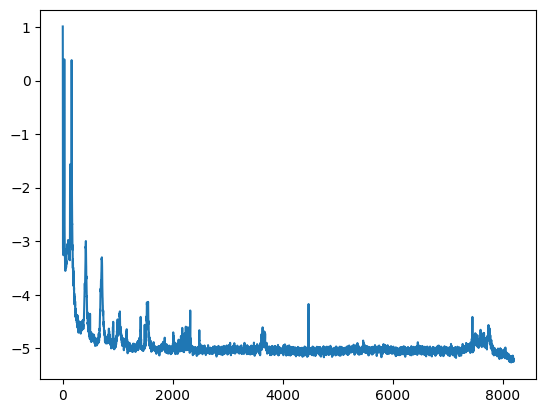

In [3]:
plt.plot(data[1])

In [4]:
from config import settings
settings.state.healthy_train.end 


'2020-10-01'

In [5]:
# Assuming settings.state.healthy_train.start and end are in 'YYYY-MM-DD' format

query_base = f'''
    SELECT id FROM data
    WHERE sensor = "accel"
    AND date BETWEEN "{settings.state.healthy_train.start}" AND "{settings.state.healthy_train.end}"
    AND corrupted = 0
'''

conn = sqlite3.connect(db_path)
c = conn.cursor()

# Execute the query and fetch all results
keys = conn.execute(query_base).fetchall()


# Close the connection


In [6]:
keys_tuple = tuple(key[0] for key in keys)

In [7]:
def load_psd(buffer):
    try :
        return np.frombuffer(buffer, dtype=np.float32)
    except:
        return None
columns = ['psd', 'level', 'direction','date']  # Specify the columns you want to select
transform_func = [load_psd, lambda x:x,lambda x:x,lambda x:x]  # Specify the transformation functions for each column

In [8]:
query_data = f'''
    SELECT {", ".join(columns)} FROM data
    WHERE sensor = "accel"
    AND id IN {keys_tuple}
'''

# Execute the query and fetch the results
data = conn.execute(query_data).fetchall()
data = data [:100]
# Close the connec


In [9]:
psds = [transform_func[0](d[0]) for d in data]
directions = [transform_func[2](d[2]) for d in data]
levels = [transform_func[1](d[1]) for d in data]
date = [transform_func[3](d[3]) for d in data]
        

    

In [10]:
psds=np.array(psds)

In [11]:
date[6:7]
directions[6:7]
levels[6:7]

[4]

(0.0, 2000.0)

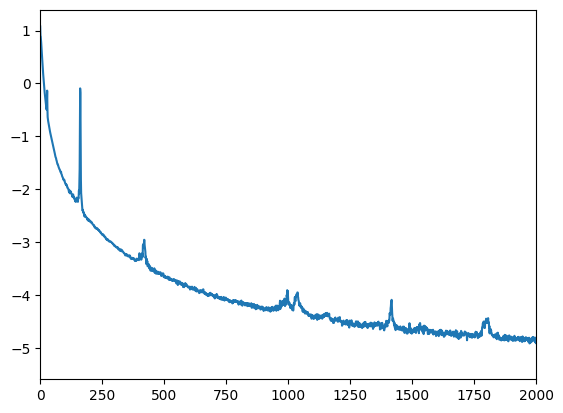

In [12]:
plt.plot(psds[6:7,:].T,label=levels[6:7],alpha=1)


plt.xlim(0, 2000)


(2000.0, 8000.0)

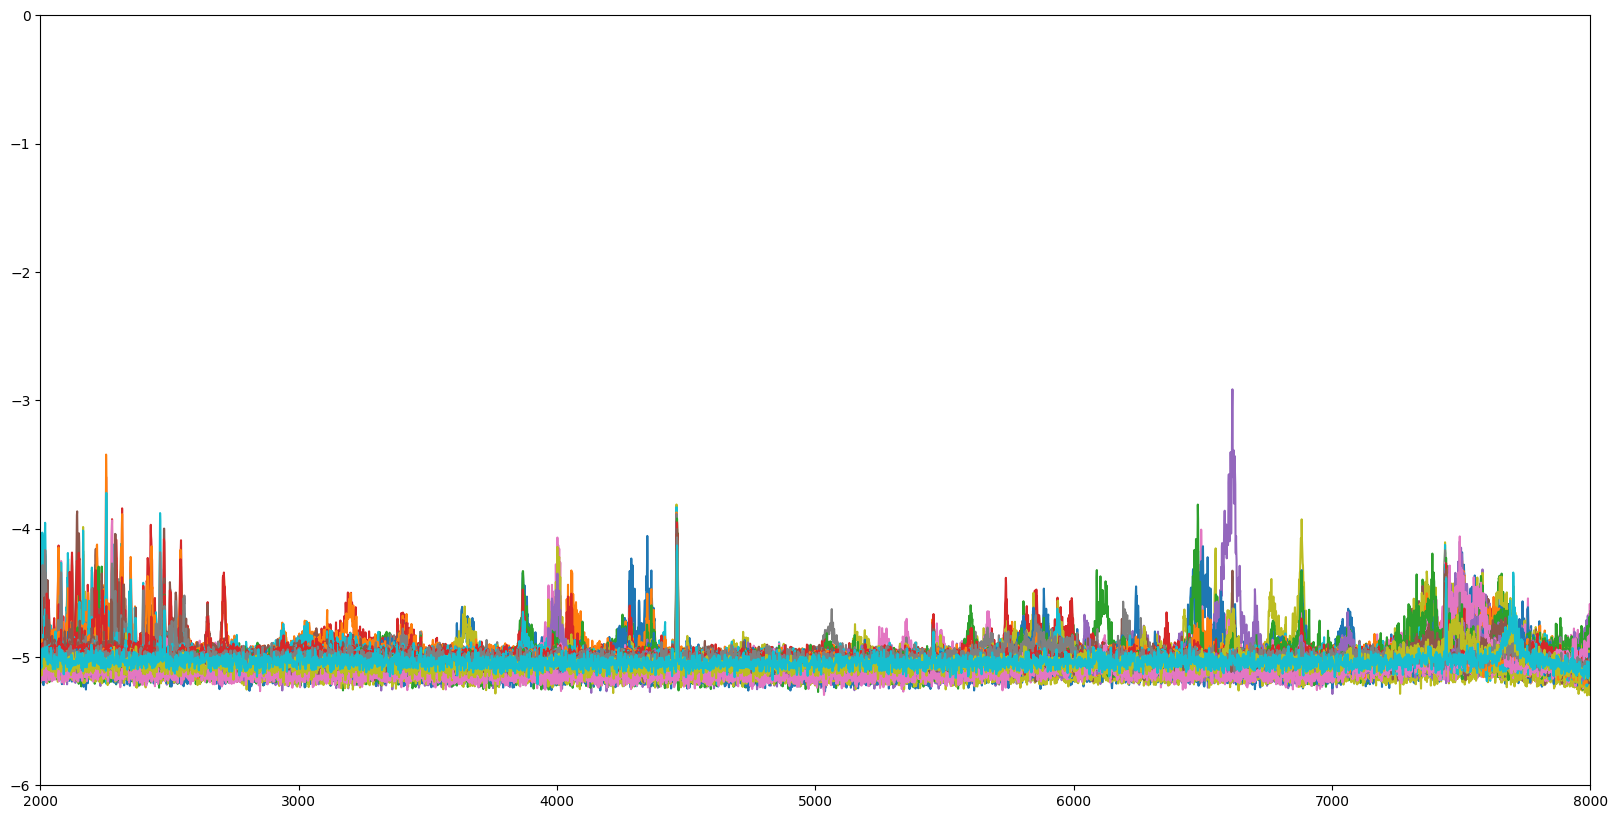

In [13]:
plt.figure(figsize=(20,10))
plt.plot(psds.T)
plt.ylim(-6,0)
plt.xlim(2000, 8000)

In [14]:
from torch.utils.data import Dataset
import sqlite3
import numpy as np

class PSDDataset(Dataset):
    def __init__(self, db_path, query_key, columns, transform_func, cached=False,return_dict=False):
        self.db_path = db_path
        self.query_key = query_key
        self.columns = columns
        self.transform_func = transform_func
        self.cached = cached
        self.return_dict = return_dict  

        # Fetch all keys based on the query_key
        conn = sqlite3.connect(self.db_path)
        c = conn.cursor()
        self.keys = c.execute(self.query_key).fetchall()
        self.keys = [key[0] for key in self.keys]
        self.length = len(self.keys)
        conn.close()

        # Define the data queries
        keys_placeholder = ','.join(['?'] * len(self.keys))  # Placeholders for parameterized query
        self.query_data = f'''
            SELECT {", ".join(self.columns)} FROM data
            WHERE sensor = "accel"
            AND id IN ({keys_placeholder})
        '''
        self.query_single = f'''
            SELECT {", ".join(self.columns)} FROM data
            WHERE id = ?
        '''

        # Cache data if requested
        self.cache_data()
        
    def cache_data(self):
        if self.cached:
            # Preload all data into memory
            conn = sqlite3.connect(self.db_path)
            c = conn.cursor()
            all_data = c.execute(self.query_data, self.keys).fetchall()
            conn.close()
            self.data = []
            for d in all_data:
                transformed = [func(val) for func, val in zip(self.transform_func, d)]
                data_dict = dict(zip(self.columns, transformed)) if self.return_dict else transformed
                self.data.append(data_dict)
        else:
            self.data = None

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if self.cached:
            # Return preloaded data as a dictionary
            return self.data[idx]
        else:
            # Fetch data on-the-fly and return as a dictionary
            conn = sqlite3.connect(self.db_path)
            c = conn.cursor()
            key = self.keys[idx]
            d = c.execute(self.query_single, (key,)).fetchone()
            conn.close()
            transformed = [func(val) for func, val in zip(self.transform_func, d)]
            data_dict = dict(zip(self.columns, transformed)) if self.return_dict else transformed
            return data_dict


In [15]:
query_key = f'''
    SELECT id FROM data
    WHERE sensor = "accel"
    AND date BETWEEN "{settings.state.healthy_train.start}" AND "{settings.state.healthy_train.end}"
    AND corrupted = 0
'''

In [16]:
from torch import nn
import torch


class FromBuffer(nn.Module):
    def __init__(self, dtype=np.float32):
        super(FromBuffer, self).__init__()
        self.dtype = dtype

    def forward(self, buffer):
        array = np.frombuffer(buffer, dtype=self.dtype)
        array = np.copy(array)  # Make the array writable
        return torch.tensor(array)


class DirectionEncoder(nn.Module):
    def __init__(self, encode: bool = True):
        super(DirectionEncoder, self).__init__()
        self.encode_map = {'x': 0, 'y': 1}
        self.decode_map = {v: k for k, v in self.encode_map.items()}
        self.encode = encode  # Store the encode parameter
        self.forward_func = {True: self.fw_encode, False: self.fw_decode}
        
    def fw_encode(self, direction: str):
        return self.encode_map[direction]

    def fw_decode(self, direction: int):
        return self.decode_map[direction]
    
    def forward(self, direction):
        return torch.tensor(self.forward_func[self.encode](direction))
    

class LevelEncoder(nn.Module):
    def __init__(self, encode: bool = True):
        super(LevelEncoder, self).__init__()
        self.encode = encode
        self.forward_func = {True: self.fw_encode, False: self.fw_decode}
    
    def fw_encode(self, level: int):
        return level -1 
    def fw_decode(self, level: int):
        return level +1
    def forward(self, level):
        return torch.tensor(self.forward_func[self.encode](level))

In [17]:
columns = ['psd', 'level', 'direction']
transform_func = [
    FromBuffer(dtype=np.float32),
    LevelEncoder(encode=True),
    DirectionEncoder(encode=True)
]
dataset = PSDDataset(
    db_path=db_path,
    query_key=query_key,
    columns=columns,
    transform_func=transform_func,
    cached=True
) 


In [18]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split, default_collate

class PSDDataModule(pl.LightningDataModule):
    def __init__(self, db_path, query_key, columns, transform_func, batch_size=32, num_workers=4):
        super().__init__()
        self.db_path = db_path
        self.query_key = query_key
        self.columns = columns
        self.transform_func = transform_func
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage=None):
        # Initialize the full dataset
        self.dataset = PSDDataset(
            db_path=self.db_path,
            query_key=self.query_key,
            columns=self.columns,
            transform_func=self.transform_func,
            cached=False  # Set to True if you want to preload data
        )

        # Split the dataset into train, val, and test sets
        dataset_size = len(self.dataset)
        train_size = int(0.8 * dataset_size)
        val_size = dataset_size - train_size
        # Use random_split to split the dataset
        self.train_dataset, self.val_dataset = random_split(
            self.dataset, [train_size, val_size]
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, batch_size=self.batch_size, shuffle=True,
            num_workers=self.num_workers, collate_fn=self.collate_fn
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, batch_size=self.batch_size, shuffle=False,
            num_workers=self.num_workers, collate_fn=self.collate_fn
        )

    def collate_fn(self, batch):
        # Custom collate function to handle dictionaries
        if isinstance(batch[0], dict):
            batch_dict = {key: [d[key] for d in batch] for key in batch[0]}
            # Convert lists to tensors if necessary
            for key in batch_dict:
                if key == 'psd':
                    batch_dict[key] = torch.stack(batch_dict[key])
                else:
                    batch_dict[key] = torch.tensor(batch_dict[key])
            return batch_dict
        else:
            # If not returning dictionaries, use default collate
            return default_collate(batch)


In [19]:
# let's test the data module
data_module = PSDDataModule(
    db_path=db_path,
    query_key=query_key,
    columns=columns,
    transform_func=transform_func,
    batch_size=10240,
    num_workers=4
)
data_module.setup()
for batch in data_module.train_dataloader():
    print(batch)
    break

[tensor([[ 0.7182,  0.1202, -1.3879,  ..., -2.8032, -2.6655, -2.6282],
        [ 0.7405,  0.1391, -3.1841,  ..., -5.1603, -5.1618, -5.1795],
        [ 1.0674,  0.4651, -3.1431,  ..., -3.6268, -3.6414, -3.7199],
        ...,
        [ 0.0409, -0.5579, -3.1103,  ..., -5.1121, -5.0705, -5.0205],
        [ 0.5615, -0.0124, -1.7971,  ..., -5.0914, -5.0973, -5.0518],
        [-0.1538, -0.5375, -1.5272,  ..., -5.1617, -5.1777, -5.2055]]), tensor([3, 1, 0,  ..., 0, 8, 5]), tensor([1, 0, 0,  ..., 1, 1, 0])]


In [20]:
import torch
import torch.nn as nn

class NormLayer(nn.Module):
    def __init__(self, max_val, min_val, denormalize=False):
        super(NormLayer, self).__init__()
        self.register_buffer('max', self._to_tensor(max_val))
        self.register_buffer('min', self._to_tensor(min_val))
        self.denormalize = denormalize
        self.forward_func = {False: self.forward_norm, True: self.forward_denorm}
        self.forward = self.forward_func[self.denormalize]

    def forward_norm(self, x):
        return (x - self.min) / (self.max - self.min + 1e-8)

    def forward_denorm(self, x):
        return x * (self.max - self.min + 1e-8) + self.min

    def _to_tensor(self, val):
        if isinstance(val, torch.Tensor):
            return val.clone().detach()
        else:
            return torch.tensor(val, dtype=torch.float32)


In [21]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size, latent_size):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            NormLayer(max_val = 4.96, min_val = -5.46, denormalize=False),
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_size)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_size),
            nn.Tanh(),
            NormLayer(max_val = 4.96, min_val = -5.46, denormalize=True))

    def forward(self, x):
        return self.decoder(self.encoder(x))
    
    def encode(self, x):
        return self.encoder(x)
    
import pytorch_lightning as pl
class ReconstructionLoss(pl.LightningModule):
    def __init__(self,input_size, latent_size):
        super(ReconstructionLoss, self).__init__()
        self.input_size = input_size
        self.latent_size = latent_size
        self.model = AutoEncoder(input_size, latent_size)
        self.loss = nn.MSELoss()
    def forward(self, x):
        x_hat = self.model(x)
        return self.loss(x_hat, x)

    def training_step(self, batch, batch_idx):
        x = batch[0]
        loss = self(x)

        self.log('train_loss', loss,on_epoch=True,prog_bar=True,logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x = batch[0]
        loss = self(x)
        self.log('val_loss', loss,on_epoch=True,prog_bar=True,logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        return optimizer

In [22]:
dataset.data[0][0].shape

torch.Size([8197])

In [23]:
# let's test the data module
data_module = PSDDataModule(
    db_path=db_path,
    query_key=query_key,
    columns=columns,
    transform_func=transform_func,
    batch_size=64,
    num_workers=4
)
data_module.setup()

In [24]:
from pytorch_lightning.loggers import CometLogger
comet_logger = CometLogger(
    api_key=settings.COMET.API_KEY,
    project_name=settings.COMET.PROJECT_NAME,
    workspace=settings.COMET.WORKSPACE)

model = ReconstructionLoss(input_size=8197, latent_size=128)
trainer = pl.Trainer(max_epochs=10,logger=comet_logger)
trainer.fit(model, data_module)


ModuleNotFoundError: Requirement 'comet-ml>=3.31.0' not met. HINT: Try running `pip install -U 'comet-ml>=3.31.0'`

<Box: {'API_KEI': 'gd2RifnioVchODAgpk637Br8f', 'PROJEXT_NAME': 'hannover', 'WORKSPACE': 'yacinebelhadj'}>